<a href="https://colab.research.google.com/github/bharadwaj240796/cs666student/blob/main/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

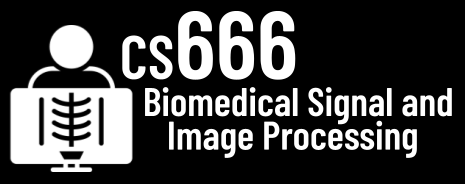
# Assignment 6

In [ ]:
# NAME: Bharadwaj Nidumolu

In [ ]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [ ]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [44]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [45]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-24 23:28:59--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.2’

mito.npz.2          100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-24 23:28:59 (321 MB/s) - ‘mito.npz.2’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [47]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

In [48]:
import matplotlib.pyplot as plt

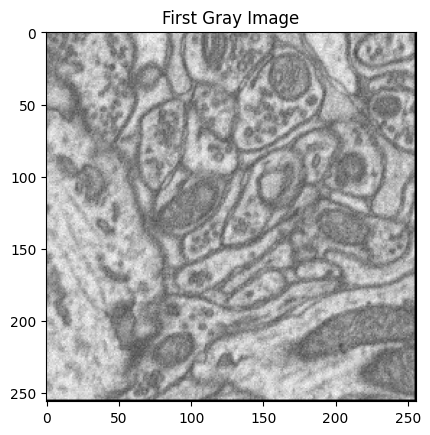

In [49]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
plt.title("First Gray Image")
plt.imshow(images[0],cmap='gray')

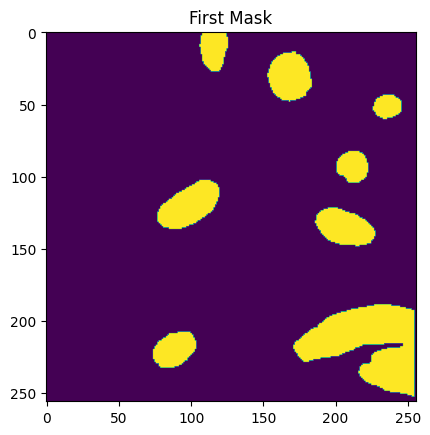

In [50]:
# TODO: Show the first mask.
plt.title("First Mask")
plt.imshow(masks[0])

## 1. SAM in AUTO mode (15 points)

In [51]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
# !pip install metaseg
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [53]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [54]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


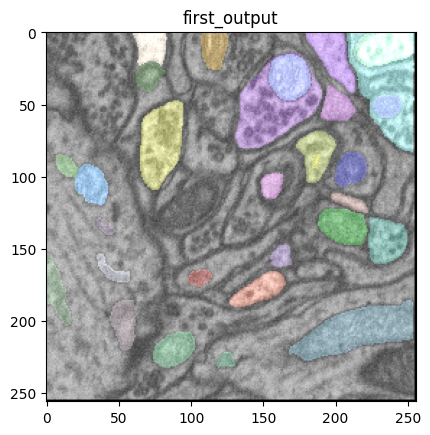

In [55]:
plt.title('first_output')
plt.imshow( mh.imread('first_output.png') )

In [ ]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER


Yes, SAM work well but not completly. We can notice , there are some segments which can also be segmented but not segmented by SAM.

In [ ]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
vit_l model already exists as 'vit_l.pth'. Skipping download.


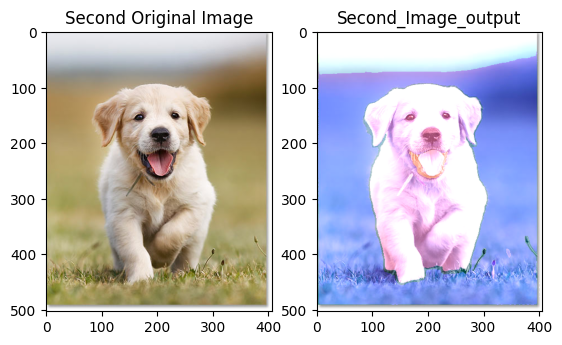

In [56]:
# TODO: YOUR CODE 
from google.colab import drive
drive.mount('/content/drive')

img = mh.imread('/content/drive/MyDrive/dog.jpg') 
plt.subplot(1,2,1)
plt.title('Second Original Image')
plt.imshow(img)
mh.imsave('Second_image.png', img)
results = SegAutoMaskPredictor().image_predict(
    source="Second_image.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="Second_output.png",
    show=False,
    save=True,
)

plt.subplot(1,2,2)
plt.title('Second_Image_output')
plt.imshow( mh.imread('Second_output.png') )

In [ ]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

Yes, SAM work well in my example. </br></br> We can easily notice segmentation original picture was excellent. where puppy, lower background and upper background was colored in different colors.

## 2. Train a U-Net classifier from scratch (50 points)


In [57]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

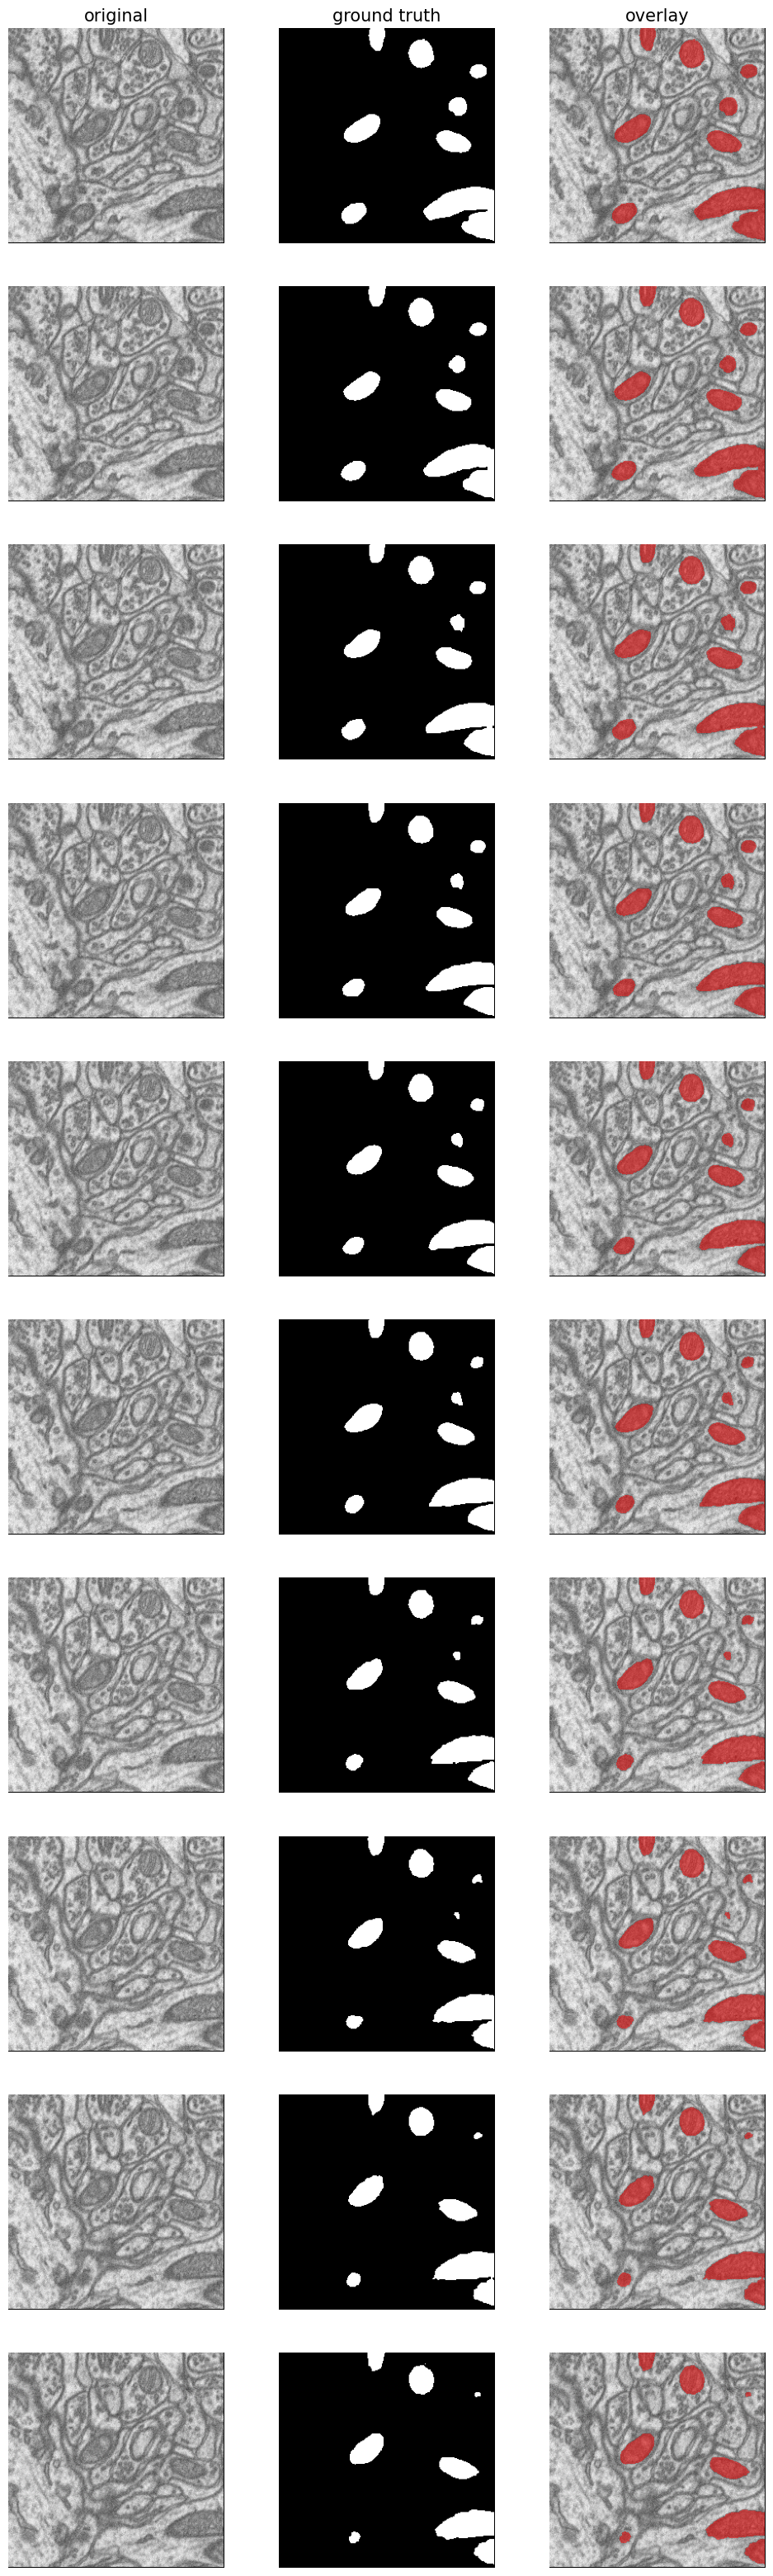

In [60]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [61]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 

In [62]:
import numpy as np

In [63]:
images = images.astype(dtype=np.float32)
print(images.dtype)
images = images/255
d1 = images.shape[0]
d2 = images.shape[1]
d3 = images.shape[2]
d4 = 1
X = images.reshape(d1, d2, d3, d4)

float32


In [64]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 0.9529412 float32


In [65]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 

In [68]:
masks = masks.astype(dtype=np.bool)
print(masks.dtype)
images = images/255
d1 = masks.shape[0]
d2 = masks.shape[1]
d3 = masks.shape[2]
d4 = 1
y = masks.reshape(d1, d2, d3, d4)

bool


<ipython-input-68-ce2494d05ba3>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks = masks.astype(dtype=np.bool)


In [69]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [70]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [73]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [ ]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

Here the sklearn.model_selection.train_test_split is used twice because the  First split is to split to train, test and the second split will split train again into validation and train

In [74]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [ ]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

*   **train_gen** is the variable name given to the generator object that will be created with the get_augmented() function.
*   **get_augmented()** is likely a custom function that generates an image data generator with augmentation parameters specified.
*   **X_train** and **y_train** are the input and target data arrays, respectively, which will be used to train a deep learning model.

*   **batch_size=2** specifies the number of samples per batch of data to be generated by the data generator.


*   **data_gen_args** is a dictionary of keyword arguments that will be passed to the image data generator for augmentation.
*   **rotation_range=15**, specifies the range of degrees for random rotations of the image.
*   **width_shift_range=0.05** and **height_shift_range=0.05** specify the range of fraction of total width/height to randomly translate the image horizontally/vertically.
* **shear_range=50** specifies the range of degrees for random shearing transformations.
* **zoom_range=0.2** specifies the range of random zoom factors to apply to the image.
* **horizontal_flip=True** and **vertical_flip=True** specify whether to randomly flip the images horizontally or vertically.
* **fill_mode='constant'** specifies the strategy for filling in any new pixels that may be created by the augmentation process.




(2, 256, 256, 1) (2, 256, 256, 1)


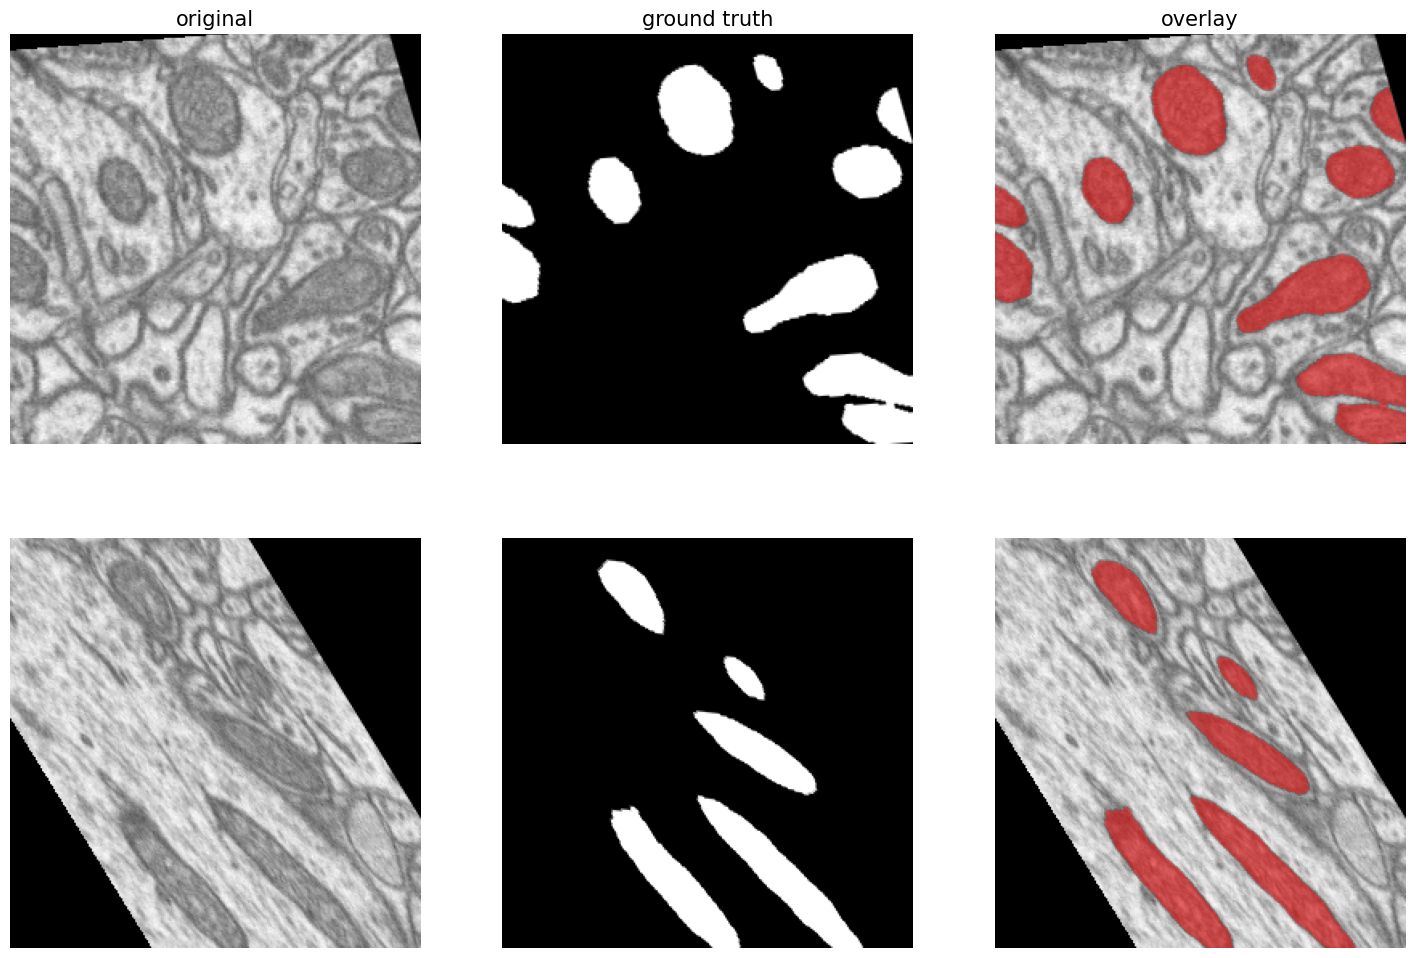

In [75]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [76]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [77]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [ ]:
# TODO: How many  trainable parameters does the model use?
# TODO: YOUR_ANSWER

Trainable params: 31,030,593

In [78]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [79]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

Intersection over Union (IoU) is an evaluation metric used to measure the accuracy of an object detector on a particular dataset. 

In [81]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    #
    # TODO: YOUR CODE
    #
    train_gen,
    steps_per_epoch=len(X_train),
    epochs=30,
    validation_data=(X_val, y_val)
    
)

Epoch 1/30
369/369 [==============================] - 109s 272ms/step - loss: 0.2391 - iou: 0.0471 - iou_thresholded: 1.4548e-04 - val_loss: 0.2718 - val_iou: 0.0907 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 59s 160ms/step - loss: 0.1822 - iou: 0.1110 - iou_thresholded: 1.6841e-04 - val_loss: 0.1797 - val_iou: 0.1428 - val_iou_thresholded: 6.0699e-06
Epoch 3/30
369/369 [==============================] - 58s 157ms/step - loss: 0.1367 - iou: 0.2393 - iou_thresholded: 0.2109 - val_loss: 0.1086 - val_iou: 0.3965 - val_iou_thresholded: 0.5095
Epoch 4/30
369/369 [==============================] - 59s 159ms/step - loss: 0.1016 - iou: 0.3634 - iou_thresholded: 0.4552 - val_loss: 0.0743 - val_iou: 0.5418 - val_iou_thresholded: 0.6803
Epoch 5/30
369/369 [==============================] - 58s 158ms/step - loss: 0.0788 - iou: 0.4702 - iou_thresholded: 0.5855 - val_loss: 0.0605 - val_iou: 0.6415 - val_iou_thresholded: 0.7373
Epoch 6/30
369/369 [========

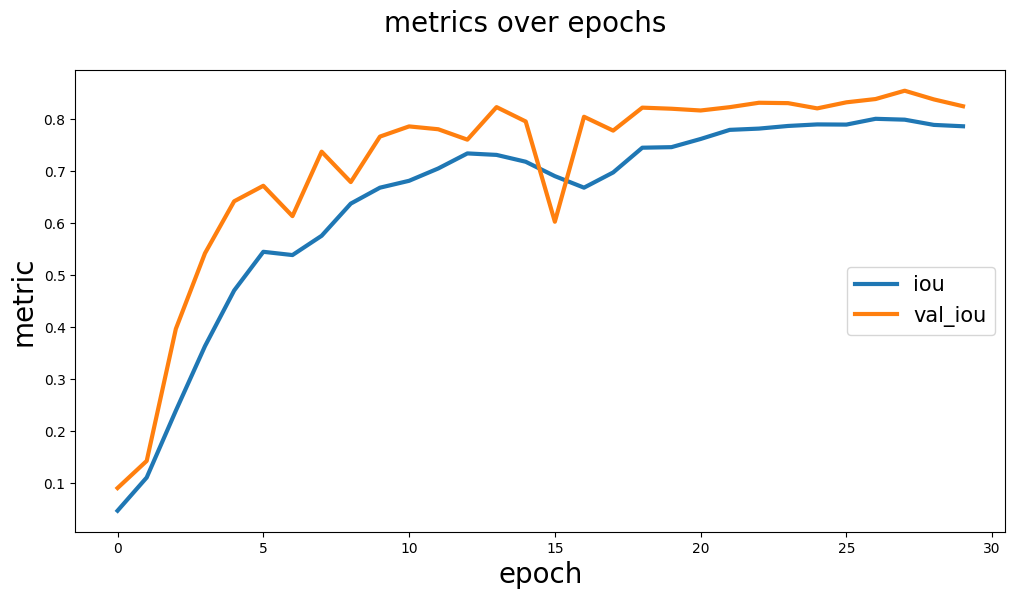

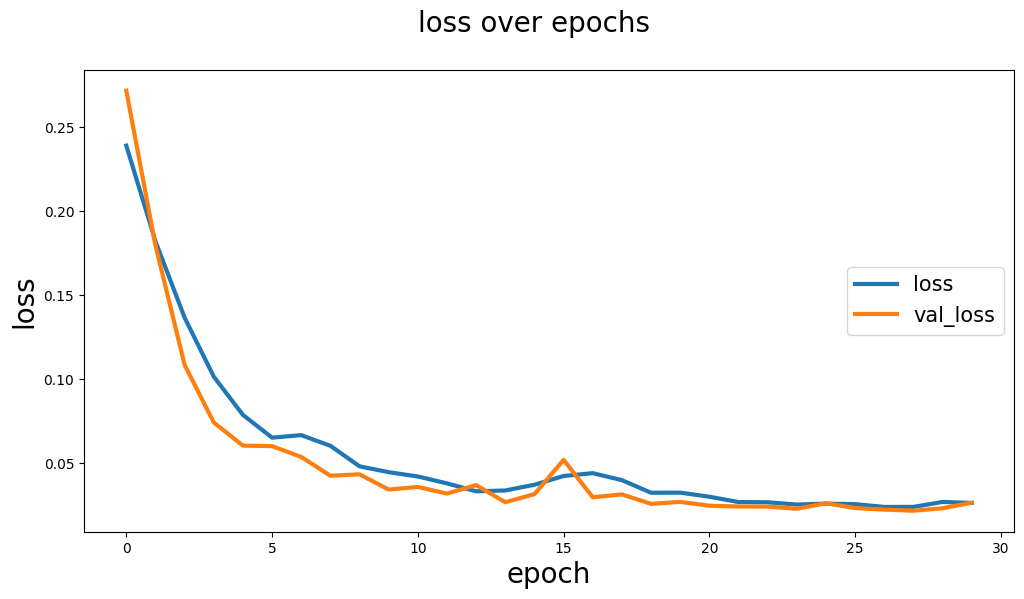

In [82]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

Yes.

## 3. Evaluate U-Net (10 points)

In [83]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 1s/step


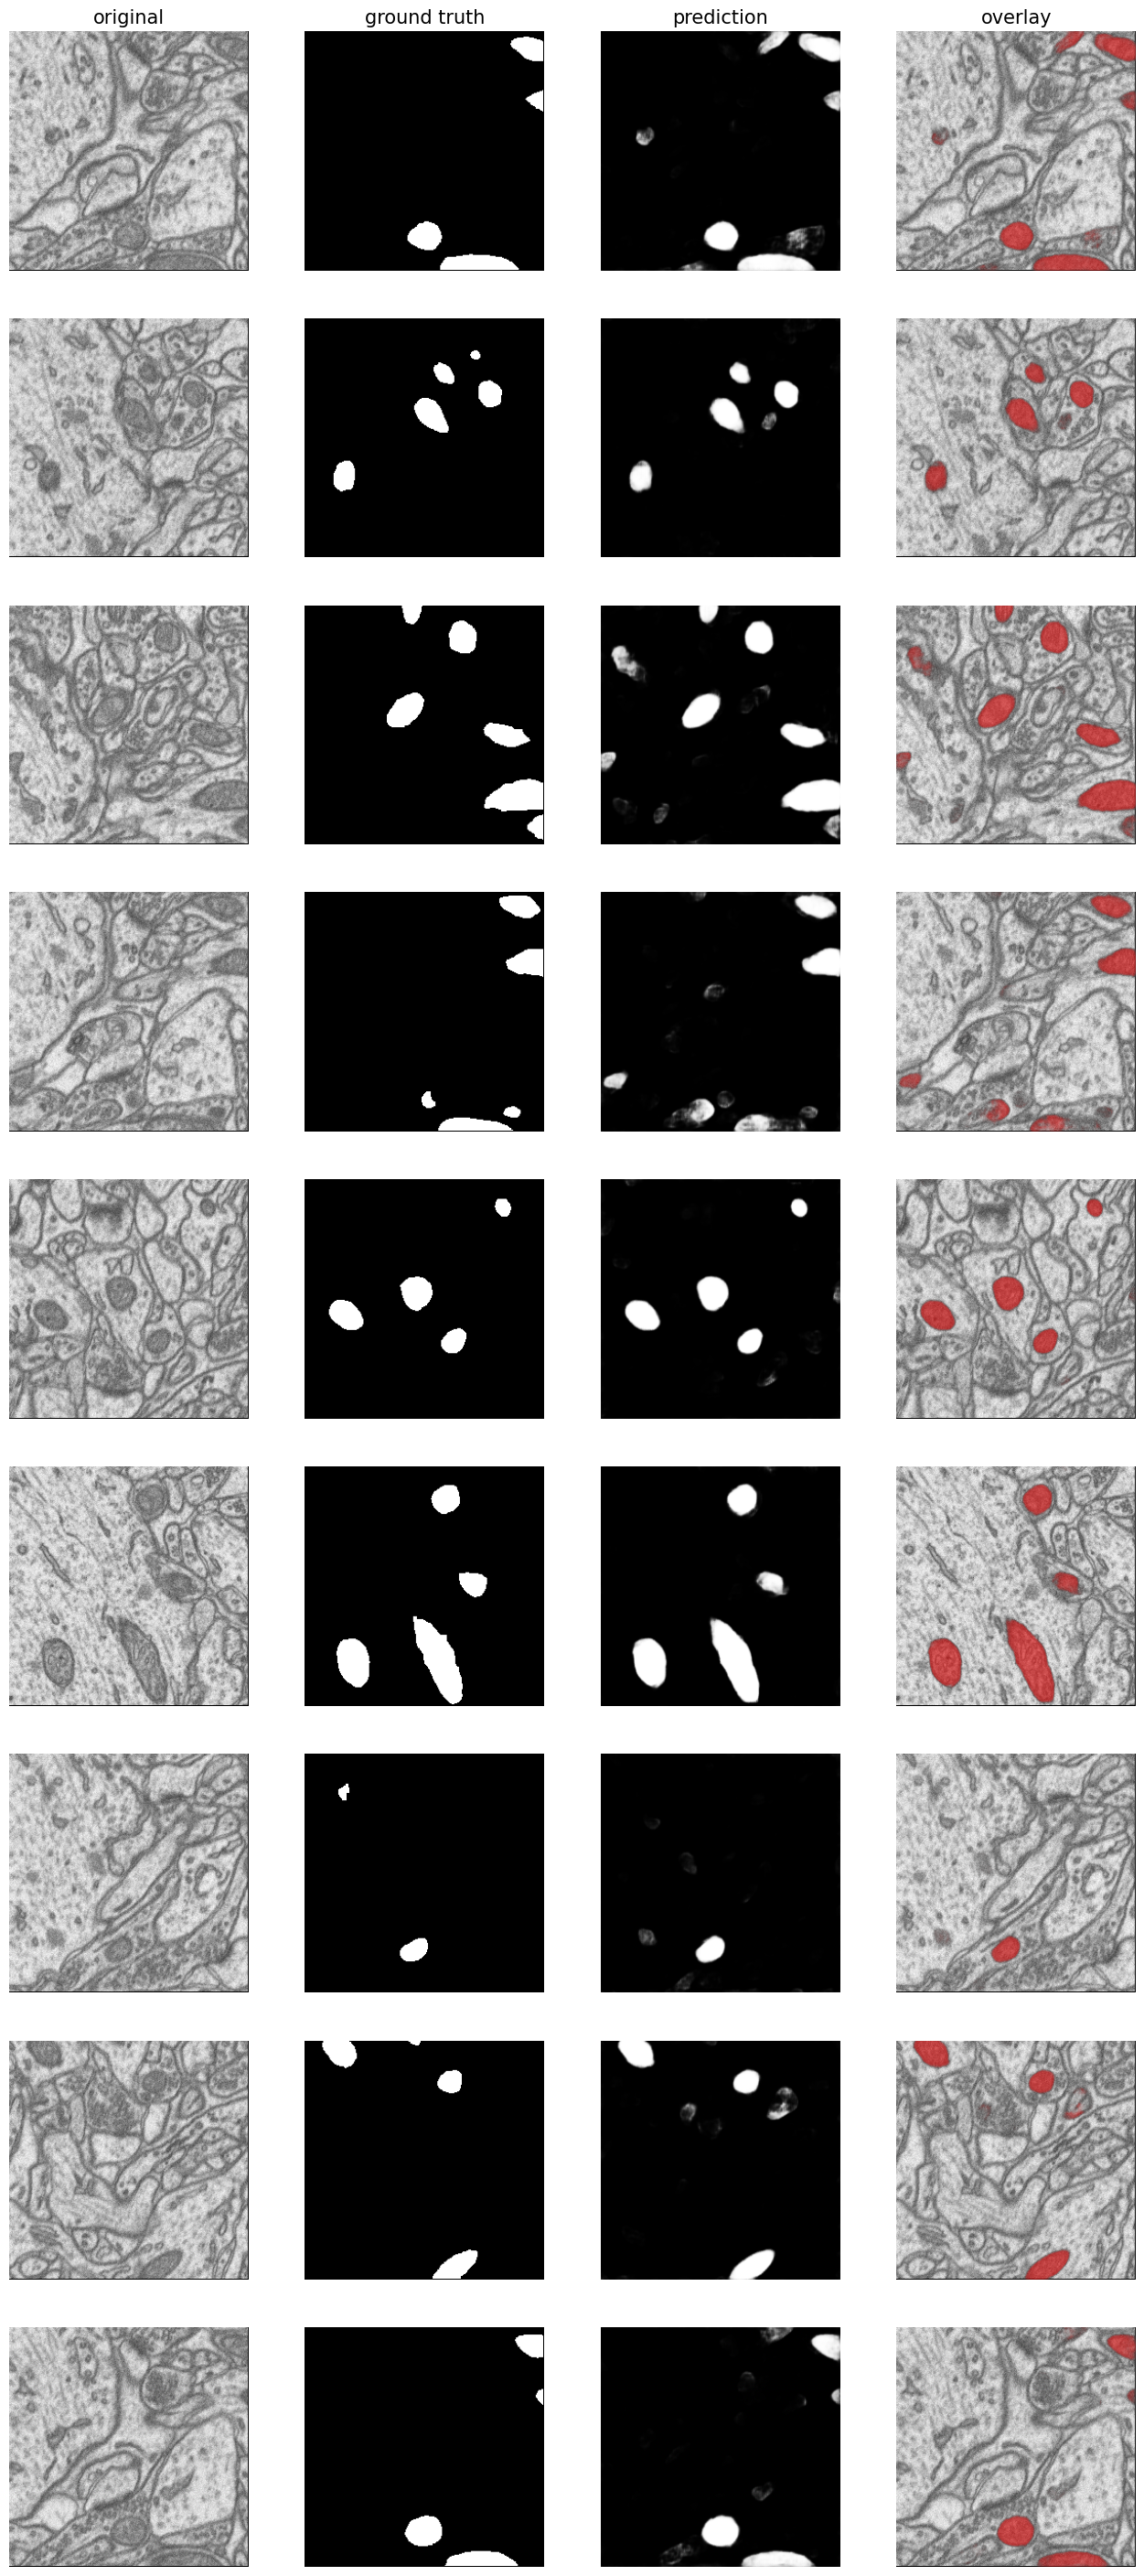

In [84]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [85]:
import sklearn.metrics

In [86]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8654959219320234

In [ ]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

The Intersection over Union (IoU) metric and the Jaccard score are similar and one of the most commonly used metrics in semantic segmentation.They are essentially a method to quantify the percent overlap between the target mask and our prediction output.

In [ ]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

From the above we can notice the jaccard score is 0.865 which is near to 1.  we can conculde that the U-Net performed good.

## 4. Combine U-Net with SAM (10 points)

In [ ]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [ ]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [87]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [88]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [92]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))
  # This line of code copies the X test image to a file called test.png`of unit8 type in range of 0 - 255.

  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.5)
  # The segmentation probabilities y_pred for the picture at index z are used to generate a binary mask pred in this line. Probabilities are converted to binary values at a threshold of 0.5.

  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
  # Using the label function from the Mahotas library, this line names the associated components in Pred.
  
  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)
  # Using the bbox function from the Mahotas library, this line determines the bounding boxes of the associated components in Pred.

  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)
  # Using the custom function mahotas_bbox_to_sam, this line changes the bounding boxes (bbs) to the format required by the SegManualMaskPredictor class.

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
  #This line use a Vision Transformer model (vit_l, vit_h, or vit_b) to predict a segmentation mask for the image in "test.png" using the SegManualMaskPredictor class.
  # The bounding boxes of the linked components to segment are specified by the input_box argument. 
  #The other options, such as whether to display the results (show=True) or store them to a file (save=True), are controlled by the other parameters.

  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)
  # The SegManualMaskPredictor's projected segmentation mask is converted in this line to the format required by the pipeline's output. The sam_to_mask custom function is used to convert data.

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred
  # In y_pred_sam, which is probably an output array for the pipeline, this line contains the anticipated segmentation mask for the picture at index z. 
  #The first channel ([:,:,0]) of the last dimension of y_pred_sam contains the expected mask.

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [93]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8654959219320234

In [94]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8291200410542972

In [ ]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER

U-Net : 0.8654959219320234</br>
U-Net + SAM : 0.8291200410542972</br></br>

Clearly , we can say U-Net+SAM is not a good condition.

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [95]:
# TODO: YOUR_CODE

y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.9)

  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
 
  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

In [96]:
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8587827689839261

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#